### 基于冰川尺度统计结果给予格网产品赋值

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import proplot as pplt
import geopandas as gpd
import rioxarray as rioxr

In [2]:
pth='D:/Key_works/20231212dh_calculate/xnhl_test'

In [3]:
gla_pth=pth+'/shp/gla_cgi1_basin.gpkg'
df_gla=gpd.read_file(gla_pth)

In [4]:
pth1=pth+'\\dh-effe-stat.csv'
#pth2='F:\\User1\\Python_code\\20210612_glacier_dh_testcode\\TerraSAR\\dh-effe-stat-terrasar.csv'

In [5]:
df_effe_dxt=pd.read_csv(pth1,index_col=0)

In [6]:
df_effe_dxt.head()

,group_id,mean,median,mean_fill,median_fill,Glc_Area,Mean_Elev,Mean_Slp,Mean_Asp,MA_Elev,basin
G101096E33298N,g0018,-2.247736,-4.501035,-2.532606,-4.124494,2.930313e+05,4942.3,39.4,315.8,4939.9,Yellow
G101108E33292N,g0018,1.705512,1.456494,1.766449,1.840311,1.968628e+06,4977.4,26.6,40.8,4998.3,Yellow
G101093E33294N,g0018,-6.184100,-3.108037,-5.655661,-3.263412,3.890786e+05,5065.6,33.5,292.3,5061.8,Yellow
G101093E33290N,g0018,-12.320572,-8.514097,-11.220770,-9.178255,2.439229e+05,5122.8,37.7,293.8,5125.4,Yellow
G101093E33286N,g0018,-5.804585,-6.774280,-5.146242,-5.558762,5.173286e+05,5035.6,30.3,228.8,5025.2,Yellow


In [7]:
df_effe_dxt['mean'].mean()

-9.524962689799008

In [8]:
dxt_ix=pth+'/shp/dxt_group_xn.shp'
df_dxt=gpd.read_file(dxt_ix)

##### 获取西南河流地形图group 信息  下次不运行

In [9]:
####选取研究区内的dh
group_lst=[]
for i in df_dxt.reg_group.values:
    if i is not None:
        ist=i.split('+')
        for j in ist:
            group_lst.append(j)
group_lst=list(set(group_lst))# 去除重复元素 保证标识的唯一性

In [10]:
len(group_lst)

261

#### 将生成的tif文件在qgis中合并

In [246]:
###生成tif后，在arcgis里合并输出为'dh1970_group/dh1970_group.tif' ##最好为int型 不然存储过大

#### 生成0.1°格网  根据审稿意见，弃用

In [11]:
pth_dh=pth+'/gla_level_dh_final/'+'xnhl_dh_all_effe.tif'
pth_yr=pth+'/gla_level_dh_final/'+'xnhl_dh_all_effe_yr.tif'
pth_err=pth+'/gla_level_dh_final/'+'xnhl_dh_all_effe_err.tif'

In [12]:
dh_all=xr.open_dataset(pth_dh,engine='rasterio')
dh_all_prj0=dh_all.rio.reproject('epsg:4326')

In [66]:
dh_all

<xarray.Dataset> Size: 13GB
Dimensions:      (band: 1, x: 77914, y: 42152)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 623kB -2.439e+06 -2.439e+06 ... -1.02e+05 -1.02e+05
  * y            (y) float64 337kB 4.122e+06 4.122e+06 ... 2.858e+06 2.858e+06
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 13GB nan nan nan nan ... nan nan nan nan

In [13]:
#dh_all_prj1=dh_all_prj0.where((dh_all_prj0>-200)&(dh_all_prj0<50))

In [14]:
#dh_all_prj0.max()

In [13]:
dh_year=xr.open_dataset(pth_yr,engine='rasterio')
dh_year_prj=dh_year.rio.reproject('epsg:4326')
#dh_year_prj=dh_year_prj.where(dh_year_prj!=dh_year_prj.attrs['_FillValue'])

In [14]:
dh_year_prj=dh_year_prj.where(dh_year_prj!=1)
dh_year_prj=dh_year_prj['band_data']

In [15]:
dh_err=xr.open_dataset(pth_err,engine='rasterio')
dh_err_prj=dh_err.rio.reproject('epsg:4326')

In [16]:
dh_err_prj=dh_err_prj['band_data']

In [19]:
#dh_err_prj

In [20]:
#error=((ng_std/ng_count**0.5)**2+ng_mean**2)**0.5  ## Wu et.al TC 2018 

In [17]:
grid_pth=pth+'/shp/grid.shp'
df_grid=gpd.read_file(grid_pth)

In [18]:
dh_all_prj=(dh_all_prj0*1)['band_data']

In [20]:
from xdem.spatialstats import nmad
res=0.1 ##分辨率
mean_all=[];err_all=[];fg_all=[];yr_all=[];dh_err=[]
for peri in df_grid['PRECTEGE'].values:
    if peri!=0:##格网中有冰川
        ddi=df_grid[df_grid['PRECTEGE']==peri]
        clat=ddi.lat.values[0]
        clon=ddi.lon.values[0]
        ###裁剪格网###################################
        dh_ddi=dh_all_prj.sel(y=slice(clat+res/2,clat-res/2),x=slice(clon-res/2,clon+res/2))
        dh_ei=dh_err_prj.sel(y=slice(clat+res/2,clat-res/2),x=slice(clon-res/2,clon+res/2))
        dh_yi=dh_year_prj.sel(y=slice(clat+res/2,clat-res/2),x=slice(clon-res/2,clon+res/2))
        ###统计数据 计算降尺度误差
        dh_ddi.name='tt'
        tst=(dh_ddi.to_dataframe()['tt']).dropna()
        count=tst.count()
        if count==0: ##格网中有冰川  但是没有dh
            mean_st=np.nan
            err=np.nan
            yr=np.nan
            dherr=np.nan
            gfg=-1
        else:
            mean_st=tst.mean()
            std_st=nmad(tst)
            err=(std_st/count**0.5)  ## Wu et.al TC 2018 
            gfg=1
            ############################
            dherr=dh_ei.median().values
            try:
                yr=int(dh_yi.where(dh_yi>1).mean().values)
            except:
                yr=1974
        #break
    else: ###格网中无冰川
        mean_st=np.nan
        err=np.nan
        yr=np.nan
        dherr=np.nan
        gfg=0
    mean_all.append(mean_st)
    err_all.append(err)
    fg_all.append(gfg)
    yr_all.append(yr)
    dh_err.append(dherr)

In [21]:
vvv=np.array(mean_all)
np.nanmean(vvv),np.nanmean(err_all),np.nanmedian(dh_err)

(-9.409756512576276, 0.2900866095670218, 3.386099934577942)

In [22]:
df_grid['dh']=np.array(mean_all)
df_grid['gla_flag']=fg_all
df_grid['dxt_year']=yr_all
df_grid['res_error']=np.array(err_all)/(2000-np.array(yr_all))
df_grid['dh_error']=np.array(dh_err).astype('float')

In [23]:
grid_new=df_grid.drop(['GID','GLA_AREA','AREA','geometry'],axis=1)
grid_new.columns=['gla_ratio','y','x','dh','gla_flag','dxt_year','res_error','dh_error']
ds_grid=grid_new.set_index(['y','x']).to_xarray()

In [24]:
ds_grid['mb']=ds_grid['dh']/(2000-ds_grid['dxt_year'])*0.85

In [25]:
## Atanu Bhattacharya el,al nature communication 2021
t=2000-ds_grid['dxt_year']
pi=0.85;pw=1;dp=0.06
mb_err=(((ds_grid['dh']/t)*(dp/pw))**2+((ds_grid['dh_error']/t)*(pi/pw))**2)**0.5
ds_grid['mb_error']=(mb_err**2+ds_grid['res_error']**2)**0.5

In [29]:
#ds_grid['mb_error'].values[ds_grid['mb_error'].values>1]=0.26

In [26]:
(ds_grid['dh']/t).median().values

array(-0.2639404)

In [27]:
ds_grid['mb'].mean().values,ds_grid['mb_error'].median().values,ds_grid['dh_error'].median().values

(array(-0.30848374), array(0.10922162), array(3.38609993))

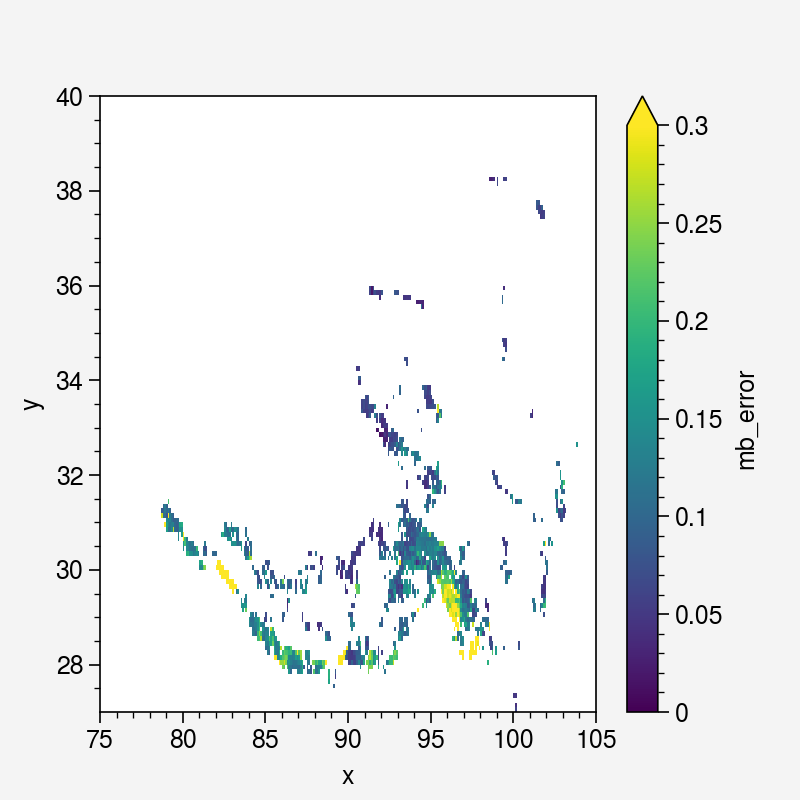

In [32]:
ds_grid['mb_error'].plot(vmax=0.3,vmin=0)

In [28]:
ds_grid['gla_flag'].attrs={'value_mean':'0->no glacier, 1->glacier&dh, -1->no dh'}

ds_grid['gla_ratio'].attrs={'long_name':'Proportion of glacier area to grid area',
                     'units':'%'}
ds_grid['dh'].attrs={'long_name':'Elevation difference from srtm-dem and topo-dem',
                     'units':'m'}
ds_grid['res_error'].attrs={'long_name':'errors in resampling',
                     'units':'m'}
ds_grid['dxt_year'].attrs={'long_name':'Year of aerial photograph'}
ds_grid['dh_error'].attrs={'long_name':'Elevation difference errors','units':'m'}
ds_grid['mb_error'].attrs={'long_name':'Mass balance errors','units':'m'}
ds_grid['mb'].attrs={'long_name':'Mass balance','units':'m'}

In [29]:
(ds_grid['dh']/(2000-ds_grid['dxt_year'])*0.85).mean(),(ds_grid['dh']).mean() ##平均年份算下来应该是27年

(<xarray.DataArray ()> Size: 8B
 array(-0.30848374),
 <xarray.DataArray 'dh' ()> Size: 8B
 array(-9.40975651))

In [30]:
ds_grid=ds_grid.sortby('y',ascending=False)
#ds_grid.attrs['transform']=(0.1, 0.0, 75, 0.0, -0.1, 40)
#####################################
ds_grid.attrs={'crs':'+proj=longlat +datum=WGS84 +no_defs',
               'transform':(0.1, 0.0, 75,0.0, -0.1, 40),
               'res': (0.1,0.1),
               'nodatavals': 'nan','coords_format':'Grid center',
               'created date':'2024-02','institute':'Yunnan University',
              'authors':'Zhu Yu; Liu Shiyin*','email':'shiyin.liu@ynu.edu.cn; yuzhu@mail.ynu.edu.cn'}


In [36]:
pth

'D:/Key_works/20231212dh_calculate/xnhl_test'

In [32]:
ds_grid1=ds_grid.rio.write_crs('epsg:4326')
ds_grid0=ds_grid1.rio.set_spatial_dims(x_dim='x',y_dim='y')
ds_grid0.to_netcdf(pth+'/dh_swr_0.1deg_1970s-2000_v3.nc')

In [36]:
ds_grid01=ds_grid0.where(ds_grid0['dh']<0)
ds_grid01=ds_grid01.rio.write_crs('epsg:4326')
ds_grid01.to_netcdf(pth+'/dh_swr_0.1deg_1970s-2000_v3_le0.nc')

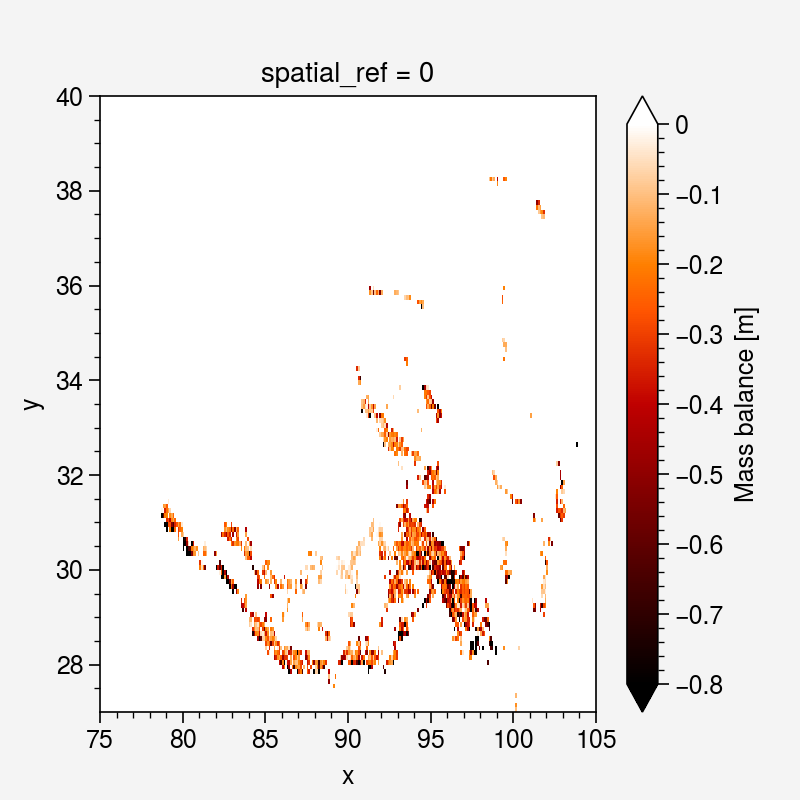

In [37]:
ds_grid0['mb'].plot(cmap='gist_heat',extend='both',vmin=-0.8,vmax=0)

In [ ]:
from osgeo import osr
pj=osr.SpatialReference()
pj.SetFromUserInput(wgs84)
strWkt=pj.ExportToProj4()

In [165]:
strWkt

'+proj=longlat +datum=WGS84 +no_defs'

#### 生成0.5°格网

In [39]:
#grid_pth='Shp_new/grid0_5.shp'
grid_pth=pth+'/shp/grid0_5.shp'
df_grid=gpd.read_file(grid_pth)

In [51]:
res=0.5 ##分辨率
mean_all=[];err_all=[];fg_all=[];yr_all=[];dh_err=[]
for peri in df_grid['gla_ratio'].values:
    if peri!=0:##格网中有冰川
        ddi=df_grid[df_grid['gla_ratio']==peri]
        clat=ddi.lat.values[0]
        clon=ddi.lon.values[0]
        ###裁剪格网###################################
        dh_ddi=dh_all_prj.sel(y=slice(clat+res/2,clat-res/2),x=slice(clon-res/2,clon+res/2))
        dh_ei=dh_err_prj.sel(y=slice(clat+res/2,clat-res/2),x=slice(clon-res/2,clon+res/2))
        dh_yi=dh_year_prj.sel(y=slice(clat+res/2,clat-res/2),x=slice(clon-res/2,clon+res/2))
        ###统计数据 计算降尺度误差
        dh_ddi.name='tt'
        tst=(dh_ddi.to_dataframe()['tt']).dropna()
        count=tst.count()
        if count==0: ##格网中有冰川  但是没有dh
            mean_st=np.nan
            err=np.nan
            yr=np.nan
            dherr=np.nan
            gfg=-1
        else:
            mean_st=tst.mean()   ##0.5
            std_st=nmad(tst)
            err=(std_st/count**0.5)  ## Wu et.al TC 2018 
            gfg=1
            ############################
            dherr=dh_ei.mean().values
            try:
                yr=int(dh_yi.where(dh_yi>1).mean().values)
            except:
                yr=1974
        #break
    else: ###格网中无冰川
        mean_st=np.nan
        err=np.nan
        yr=np.nan
        dherr=np.nan
        gfg=0
    mean_all.append(mean_st)
    err_all.append(err)
    fg_all.append(gfg)
    yr_all.append(yr)
    dh_err.append(dherr)

In [52]:
vvv=np.array(mean_all)
np.nanmean(vvv),np.nanmedian(err_all),np.nanmean(dh_err)

(-9.23290626692578, 0.10499256450557659, 3.5515574202304934)

In [53]:
df_grid['dh']=np.array(mean_all)
df_grid['res_error']=err_all
df_grid['gla_flag']=fg_all
df_grid['year']=yr_all
df_grid['dh_error']=np.array(dh_err).astype(float)

In [54]:
grid_new=df_grid.drop(['gla_area','grid_area','geometry'],axis=1)
grid_new.columns=['gla_ratio','y','x','dh','res_error','gla_flag','dxt_year','dh_error']
ds_grid=grid_new.set_index(['y','x']).to_xarray()

In [55]:
ds_grid['mb']=ds_grid['dh']/(2000-ds_grid['dxt_year'])*0.85

In [56]:
## Atanu Bhattacharya el,al nature communication 2021
t=2000-ds_grid['dxt_year']
pi=0.85;pw=1;dp=0.06
mb_err=(((ds_grid['dh']/t)*(dp/pw))**2+((ds_grid['dh_error']/t)*(pi/pw))**2)**0.5
ds_grid['mb_error']=(mb_err**2+(ds_grid['res_error']-0.1)**2)**0.5
#ds_grid['mb_error'].values[ds_grid['mb_error'].values>1]=0.3

In [57]:
ds_grid['mb'].mean().values,ds_grid['mb_error'].median().values

(array(-0.29077758), array(0.13221596))

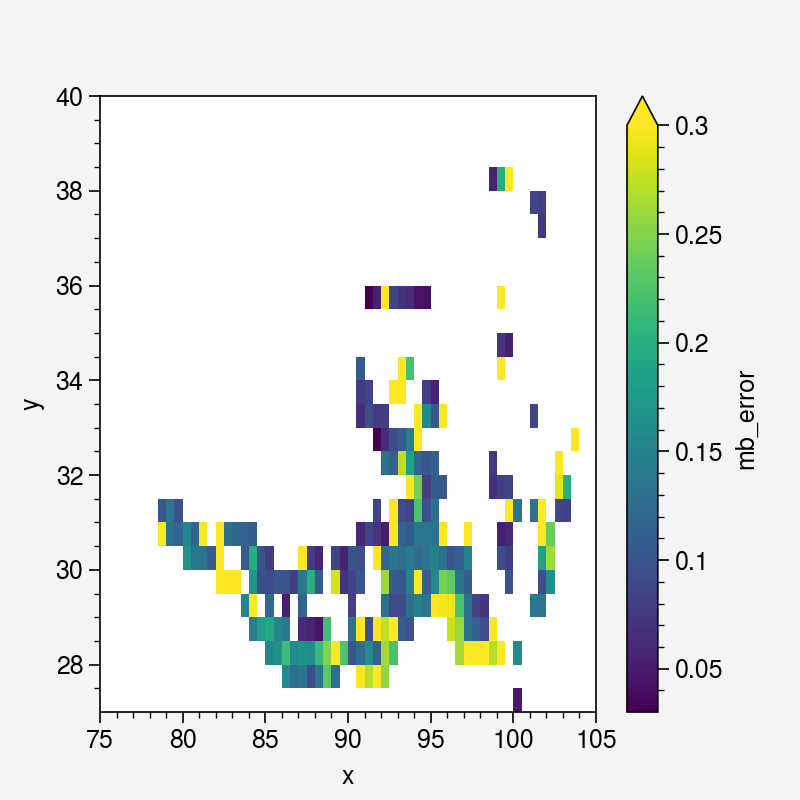

In [58]:
ds_grid['mb_error'].plot(vmax=0.3)

In [59]:
ds_grid['gla_flag'].attrs={'value_mean':'0->no glacier, 1->glacier&dh, -1->no dh'}

ds_grid['gla_ratio'].attrs={'long_name':'Proportion of glacier area to grid area',
                     'units':'%'}
ds_grid['dh'].attrs={'long_name':'Elevation difference from srtm-dem and topo-dem',
                     'units':'m'}
ds_grid['res_error'].attrs={'long_name':'errors in resampling',
                     'units':'m'}
ds_grid['dxt_year'].attrs={'long_name':'Year of aerial photograph'}
ds_grid['dh_error'].attrs={'long_name':'Elevation difference errors','units':'m'}
ds_grid['mb_error'].attrs={'long_name':'Mass balance errors','units':'m'}
ds_grid['mb'].attrs={'long_name':'Mass balance','units':'m'}

In [60]:
ds_grid=ds_grid.sortby('y',ascending=False)
#ds_grid.attrs['transform']=(0.1, 0.0, 75, 0.0, -0.1, 40)
#####################################
ds_grid.attrs={'crs':'+proj=longlat +datum=WGS84 +no_defs',
               'transform':(0.5, 0.0, 75,0.0, -0.5, 40),
               'res': (0.5,0.5),
               'nodatavals': 'nan','coords_format':'Grid center',
               'created date':'2024-02','institute':'Yunnan University',
              'authors':'Zhu Yu; Liu Shiyin*','email':'shiyin.liu@ynu.edu.cn; yuzhu@mail.ynu.edu.cn'}


In [61]:
(ds_grid['dh']/(2000-ds_grid['dxt_year'])*0.85).mean(),ds_grid['dh'].mean()

(<xarray.DataArray ()> Size: 8B
 array(-0.29077758),
 <xarray.DataArray 'dh' ()> Size: 8B
 array(-9.23290627))

In [62]:
ds_grid1=ds_grid.rio.write_crs('epsg:4326')
ds_grid0=ds_grid1.rio.set_spatial_dims(x_dim='x',y_dim='y')
ds_grid0.to_netcdf(pth+'/dh_swr_0.5deg_1970s-2000_v3.nc')

In [65]:
ds_grid01=ds_grid0.where(ds_grid0['dh']<0)

ds_grid01=ds_grid01.rio.write_crs('epsg:4326')
ds_grid01.to_netcdf(pth+'/dh_swr_0.5deg_1970s-2000_v3_le0.nc')

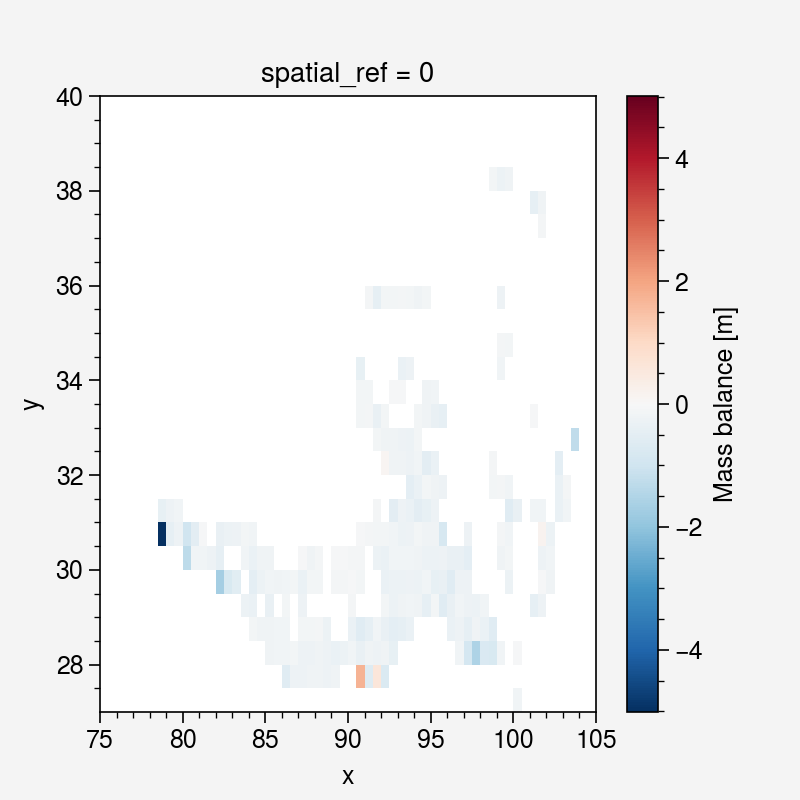

In [64]:
ds_grid0['mb'].plot()

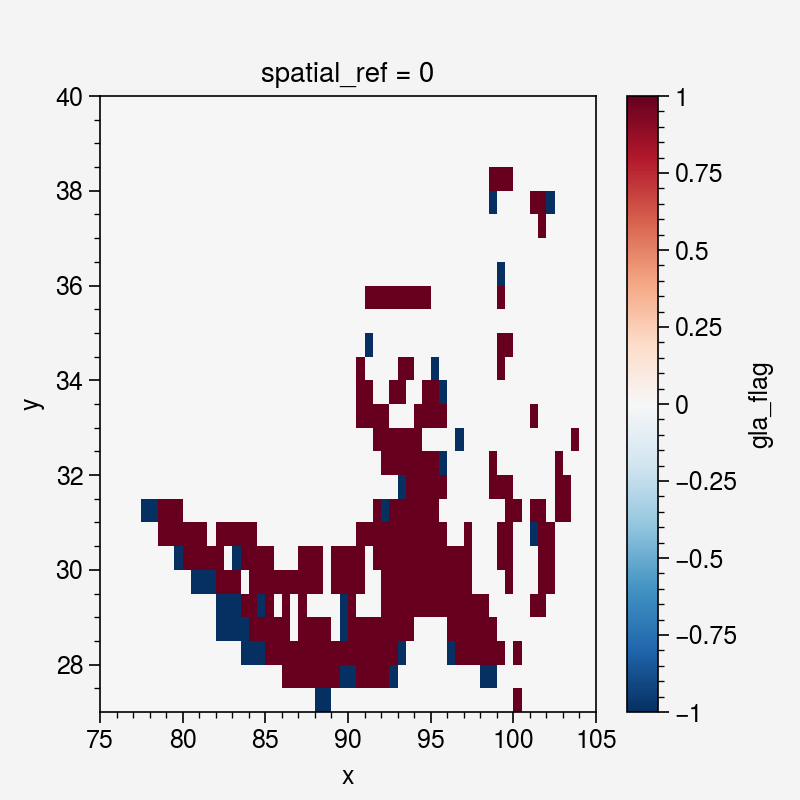

In [97]:
ds_grid0['gla_flag'].plot()